* Look at time difference between Fraser stations max U velocity with Central Node max V velocity to see how surface currents go around.

In [1]:
from __future__ import division

from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
from salishsea_tools.nowcast import figures

from matplotlib import pylab
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
from matplotlib import animation
import scipy.io as sio
import datetime
import glob
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 77, #426 start from 349 fortran start from 350
        'j' : 34, #293 start from 259 fortran start from 260
   
    },
    'Steveston Jetty':{
        'lat': 49.1057,
        'lon': -123.3032,
        'i' :  79,#428
        'j' :  33,#292
    },
    'Deas Island':{
        'lat' : 48.12,
        'lon' : -123.07,
        'i' : 65,#414,
        'j' : 69,#328
    },    
    'New Westminster': {
        'lat': 49.21,
        'lon': -122.89,
        'i': 69,#418,
        'j': 106,#365
        },

    'Mission': {
        'lat': 48.59,
        'lon': -123.2,
        'i':  151,#500,
        'j':108,#367
    },
    'VENUS East':{
        'lat': 49.0419,
        'lon': -123.3176,
        'depth': 170, 
        'i': 67,##should be 416,
        'j': 24,##should be 283
    },
    'VENUS Central':{
        'lat': 49.0401,
        'lon': -123.4261,
        'depth': 300,
        'i': 75,##should be 424,
        'j': 7,##should be 266
    },
    
        }

## location of Steveston from EC is:
#-123.185, 49.1242, so 13km away from
#our location for that in the model 

# Load simulation result

In [3]:
plume_u = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume06160629gridU.nc')
plume_v = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume06160629gridV.nc')

In [4]:
u = plume_u.variables['vozocrtx']
v = plume_v.variables['vomecrty']
time = plume_u.variables['time_counter'][:]
t = nc_tools.timestamp(plume_u, np.arange(time.shape[0]))
for ind in range(len(t)):
    t[ind] = t[ind].datetime
tt = np.array(t) ## convert time_counter into datetime

In [5]:
def plot_UV_timeseries(tt,sites, station_name, u, v):
    """This function was made to look at time difference
        of U velocity in the Fraser River and V velocity
        at East Node 
        tt: time series
        sites: with a variety of station names
        statin_name: the specific station name I want to look at
        u: U velocity array
        v: V velocity array"""

    zero_line = np.zeros(tt.shape)
    fig, axs = plt.subplots(1,1, figsize = (22,8))
    ST, = axs.plot(tt, u[:, 0, sites[station_name]['i'],\
                         sites[station_name]['j']],'b*-')
    EN, = axs.plot(tt, v[:, 0, sites['VENUS East']['i'],\
                         sites['VENUS East']['j']],'ro-')## east node
    CN, = axs.plot(tt, v[:, 0, sites['VENUS Central']['i'], \
                         sites['VENUS Central']['j']],'go-')## central node
    axs.plot(tt,zero_line,'-k')
    plt.setp(axs.get_xticklabels(), fontsize=20)
    plt.setp(axs.get_yticklabels(), fontsize=20)
    axs.legend([ST,EN, CN],[station_name,'East node','Central node'],loc = 1, fontsize = 15)
    axs.set_ylim([-1.5, 1.0])
    axs.set_ylabel('U,V velocity [m/s]', fontsize = 15)
    return fig

# Plot

* Sandheads 

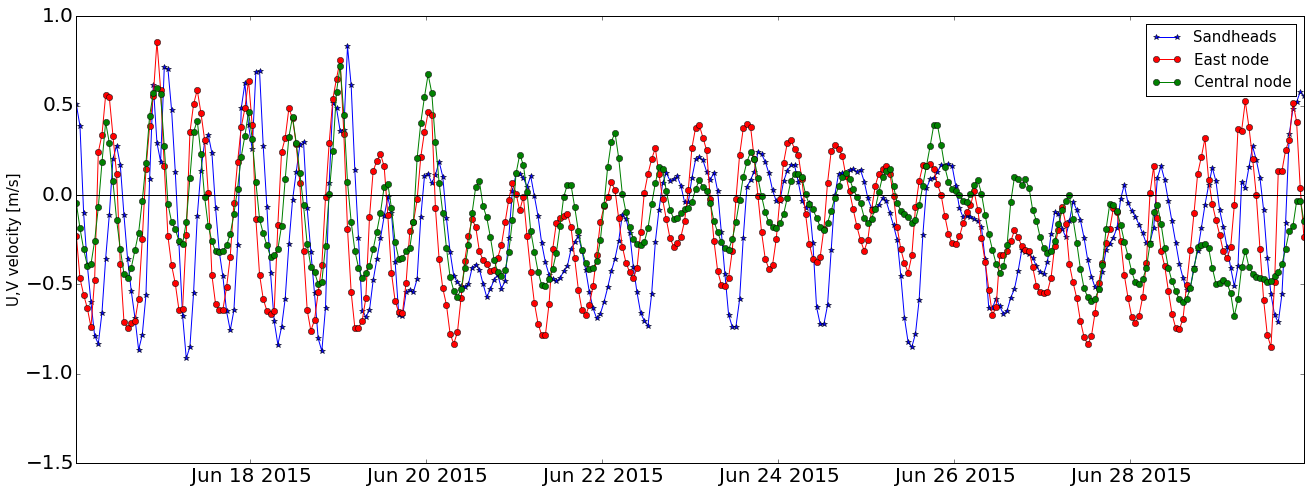

In [6]:
fig = plot_UV_timeseries(tt, sites, 'Sandheads', u, v)

* Deas Island Channel 

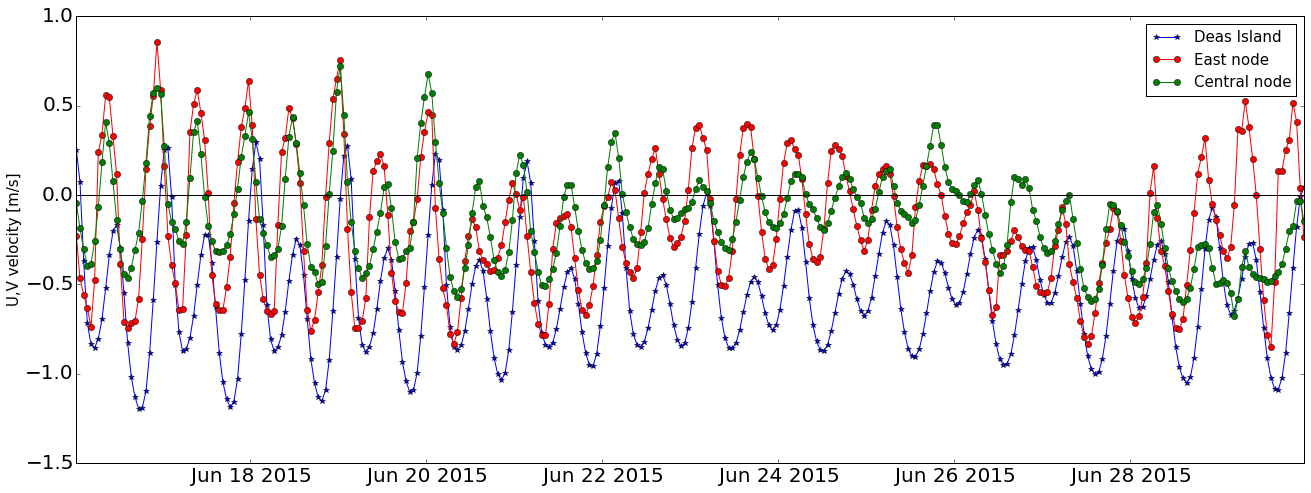

In [7]:
fig = plot_UV_timeseries(tt, sites, 'Deas Island', u, v)

* Flood tide: U > 0, V max occurs first, makes sense to me.
* Ebb tide: U < 0, V max occurs first as well, for example, Deas Island Umax 1hr later than Vmax at East node, does this mean Umax has propagate in the strait already??

* New Westminster has no U velocity due to the river channel I made, it's at the corner direct to north

  * Mission 

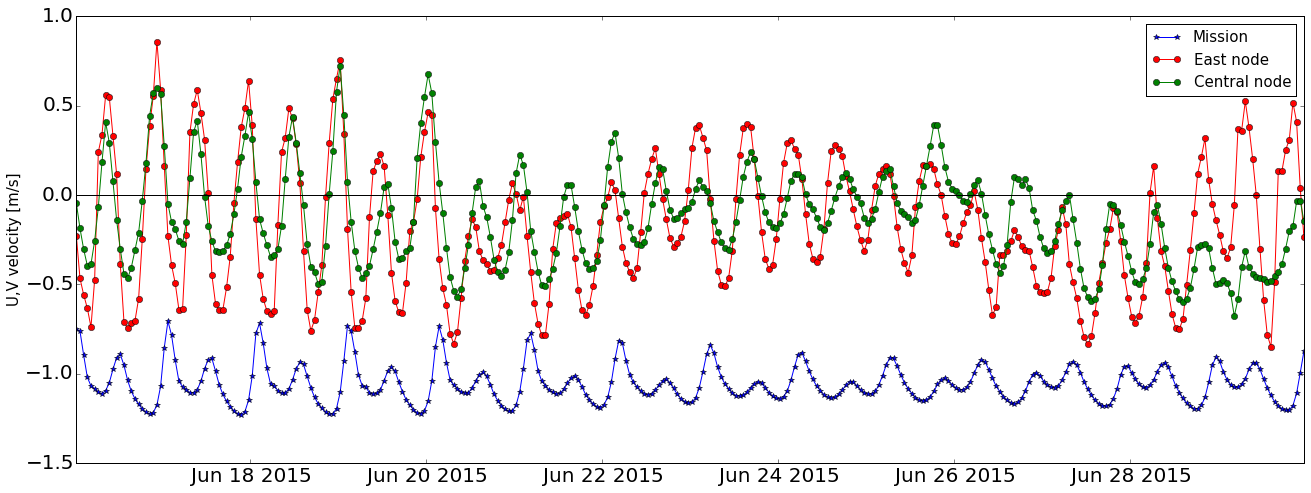

In [8]:
fig = plot_UV_timeseries(tt, sites, 'Mission', u, v)

* U always negative in Mission no matter flood/ebb tide. In this case, U should be a combination of river flow velocity and tidal current velocity. U still has daily signal variation which means Mission in our model is still affected by tides.